# Implementing Self-supervised Learning on CIFAR-10

Let's import the necessary libraries

In [ ]:
try:
    from astra.torch.models import ResNetClassifier
    import umap.umap_ as umap
except:
    %pip install git+https://github.com/sustainability-lab/ASTRA
    %pip install umap-learn

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import numpy as np
import pandas as pd
import umap.umap_ as umap

from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.spatial.distance import hamming

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import EfficientNet, MLP, MLPClassifier, EfficientNetClassifier

from itertools import permutations,product

/home/vannsh.jani/miniconda3/lib/python3.11/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/vannsh.jani/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading Data

In [3]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
range of image values: min=0.0, max=1.0
            

In [4]:
# Resizing images
X = F.interpolate(dataset.data, size=(33, 33), mode='bilinear', align_corners=False)
X.shape

torch.Size([60000, 3, 33, 33])

### Plotting some images

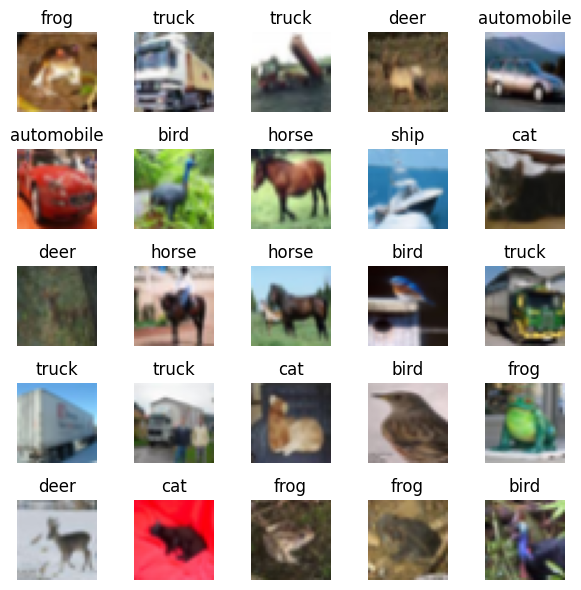

In [5]:
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", X[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

### Splitting Data

In [6]:
n_train = 10000
n_test = 40000

y = dataset.targets
print(X[0].shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

torch.Size([3, 33, 33])
torch.Size([60000, 3, 33, 33]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [7]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

10000 10000 40000


In [8]:
result_dict = {}
# 1% of the training data
train_idx_1 = train_idx[:100]
# 5% of the training data
train_idx_5 = train_idx[:500]
# 10% of the training data
train_idx_10 = train_idx[:1000]
# 50% of the training data
train_idx_50 = train_idx[:5000]

In [9]:
ecf = EfficientNetClassifier(n_classes=10).to(device) 
# mlp = MLPClassifier(hidden_dims=[])

In [10]:
def get_metrics(y_pred,y_label):
    acc = accuracy_score(y_label,y_pred)
    f1 = f1_score(y_label,y_pred,average='macro')
    precision = precision_score(y_label,y_pred,average='macro')
    recall = recall_score(y_label,y_pred,average='macro')
    return acc,f1,precision,recall

def predict(model,X_test,y_test,percent,ssl):
    model.eval()
    with torch.no_grad():
        y_pred = model.predict(X_test)
        y_pred = torch.argmax(y_pred,dim=1)
        y_pred = y_pred.cpu().numpy()
        y_test = y_test.cpu().numpy()
        acc,f1,precision,recall = get_metrics(y_pred,y_test)

        result_dict[percent+" "+ssl] = {"accuracy":acc,"f1":f1,"precision":precision,"recall":recall}

### Training model on train set 1%

100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


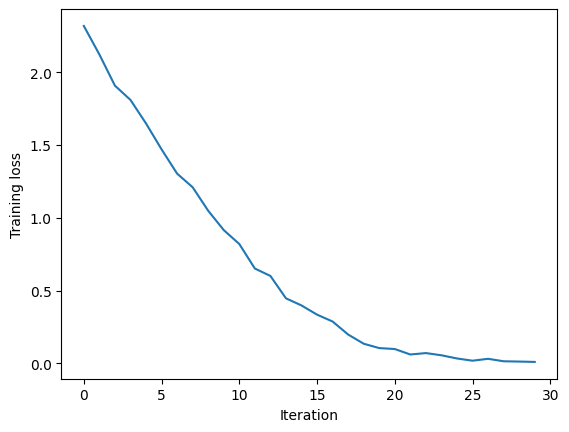

In [11]:
iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx_1], y[train_idx_1], lr=3e-4,
                                     batch_size=128, epochs=30, verbose=True)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
predict(ecf,X[test_idx],y[test_idx],"1%","no_SSL")

### Training model on train set 5%

100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


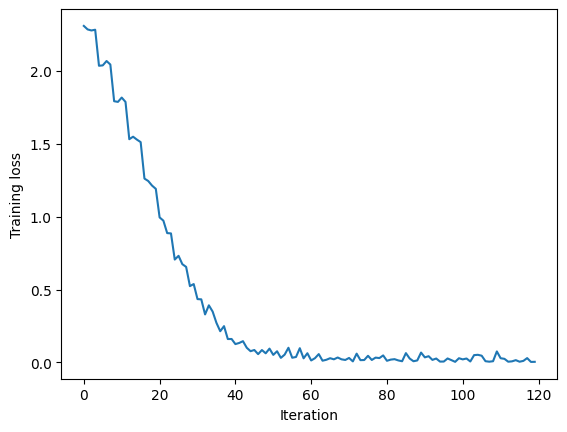

In [12]:
ecf = EfficientNetClassifier(n_classes=10).to(device)
iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx_5], y[train_idx_5], lr=3e-4,
                                     batch_size=128, epochs=30, verbose=True)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
predict(ecf,X[test_idx],y[test_idx],"5%","no_SSL")

### Training model on train set 10%

100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


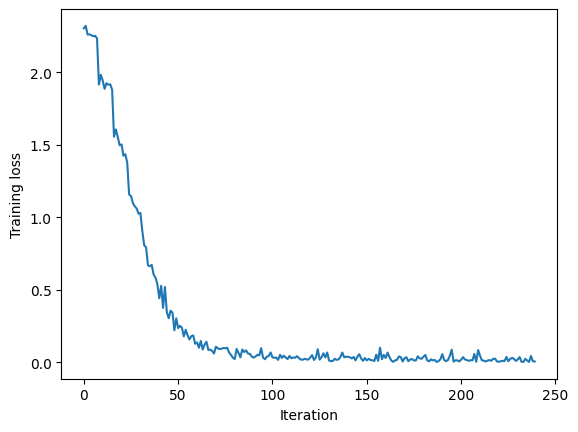

In [13]:
ecf = EfficientNetClassifier(n_classes=10).to(device)
iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx_10], y[train_idx_10], lr=3e-4,
                                     batch_size=128, epochs=30, verbose=True)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
predict(ecf,X[test_idx],y[test_idx],"10%","no_SSL")

### Training model on train set 50%

100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


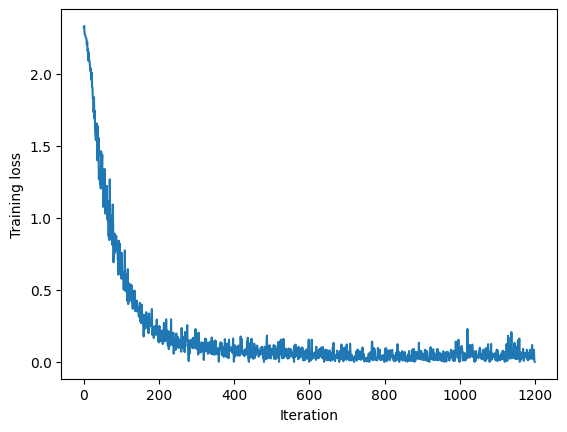

In [14]:
ecf = EfficientNetClassifier(n_classes=10).to(device)
iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx_50], y[train_idx_50], lr=3e-4,
                                     batch_size=128, epochs=30, verbose=True)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
predict(ecf,X[test_idx],y[test_idx],"50%","no_SSL")

### Training model on train set 100%

100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


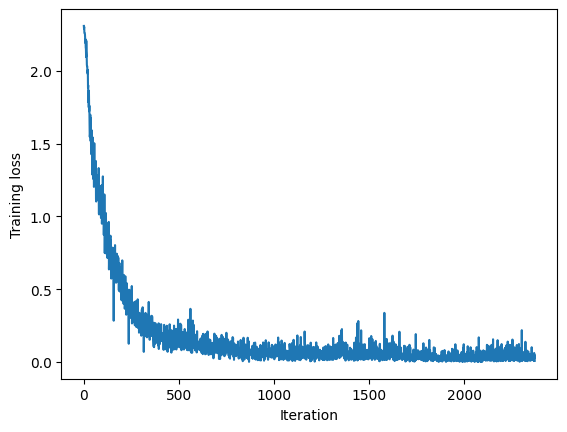

In [15]:
ecf = EfficientNetClassifier(n_classes=10).to(device)
iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx], y[train_idx], lr=3e-4,
                                     batch_size=128, epochs=30, verbose=True)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
predict(ecf,X[test_idx],y[test_idx],"100%","no_SSL")

### Oracle without SSL

100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


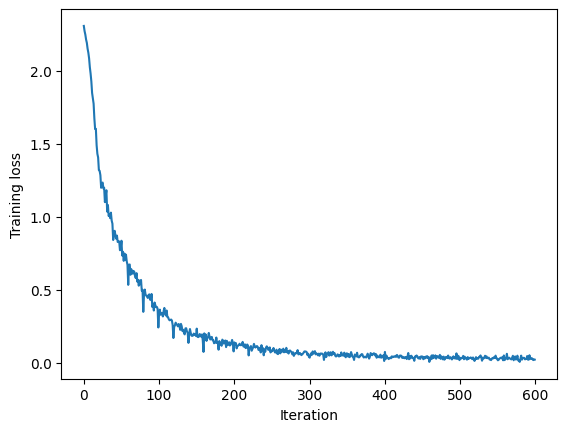

In [16]:
### Train on train + pool
ecf = EfficientNetClassifier(n_classes=10).to(device)
train_plus_pool_idx = torch.cat([train_idx, pool_idx])
iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_plus_pool_idx], y[train_plus_pool_idx],
                                     lr=3e-4,
                                        batch_size=1024, epochs=30)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
predict(ecf,X[test_idx],y[test_idx],"Oracle","no_SSL")

## SSL

Task: Dividing images into patches and permuting them. Predict the permutation number as a classification task

In [17]:
X_pool = X[pool_idx]
y_pool = y[pool_idx]

X_pool.shape, y_pool.shape

(torch.Size([10000, 3, 33, 33]), torch.Size([10000]))

In [18]:
# Divinding image into 9 patches
def divide_into_patches(images):                 
  patches = torch.split(images,11,dim=3)
  # print(patches[0].shape)
  patches = [torch.unsqueeze(patch,1) for patch in patches]
  # print(patches[2].shape,len(patches))
  patches = torch.cat(patches,dim=1)
  patches = torch.split(patches,11,dim=3)
  patches = torch.cat(patches,dim=1)
  return patches


images_with_patches = divide_into_patches(X_pool)
images_with_patches.shape

torch.Size([10000, 9, 3, 11, 11])

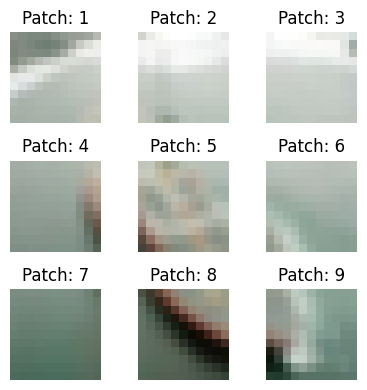

In [19]:
# Viusalizing patches
sample_image = images_with_patches[0]
plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(torch.einsum("chw->hwc", sample_image[i]))
    plt.axis('off')
    plt.title(f"Patch: {i+1}")
plt.tight_layout()

torch.Size([3, 33, 33])


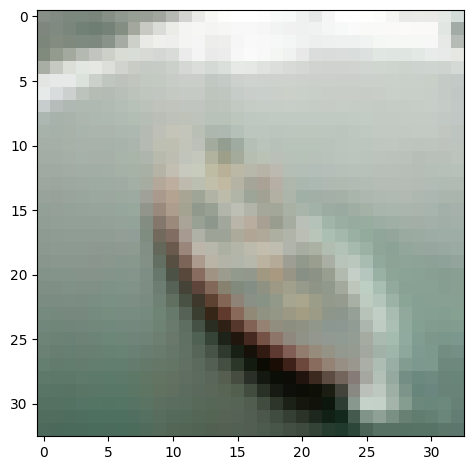

In [20]:
# Original image
print(X_pool[0].shape)
plt.imshow(torch.einsum("chw->hwc", X_pool[0]))
plt.tight_layout()

In [21]:
def top_k_hamming(k):
    # find k permutations with highest hamming distance
    permuts_list = list(permutations(range(9)))
    permuts_array = np.array(permuts_list)
    no_permuts = len(permuts_list)

    permuts_to_take = k
    set_of_taken = set()
    cnt_iterations = 0
    while True:
        cnt_iterations += 1
        x = np.random.randint(0, no_permuts )
        y = np.random.randint(0, no_permuts )
        permut_1 = permuts_array[x]
        permut_2 = permuts_array[y]
        hd = hamming(permut_1, permut_2)

        if hd > 0.9 and (not x in set_of_taken) and (not y in set_of_taken):
            set_of_taken.add(x)
            set_of_taken.add(y)

            if len(set_of_taken) == permuts_to_take:
                break

        # if cnt_iterations % 100 == 0:
        #     print ("Already performed count of iterations with pairs of jigsaw permutations", cnt_iterations)
        #     print ("Length of set of taken: ",len(set_of_taken))

    # print ("No of iterations it took to build top - {} permutations array = {}".format(permuts_to_take, cnt_iterations))
    # print ("No of permutations", len(set_of_taken))
    selected_permuts = []
    for ind, perm_id in enumerate(set_of_taken):
        selected_permuts.append(permuts_array[perm_id])
    selected_permuts = np.array(selected_permuts)
    selected_permuts = torch.tensor(selected_permuts)
    return selected_permuts
    

def temp_func(image):
    # image shape is 9,3,11,11

    selected_perms = top_k_hamming(k=64)
    p_image = torch.unsqueeze(image,0)
    for i in range(len(selected_perms)):
        p_image = torch.cat([p_image,torch.unsqueeze(image[selected_perms[i]],0)],dim=0)
    p_image = p_image[1:]
    return p_image



def permute_image(images,number_of_permutations):
    
    p_images = torch.vmap(temp_func)(images)
    shape1 = (10000,9,3,11,11)
    shape2 = (10000)
    final_images = torch.zeros(shape1)
    y_labels = torch.zeros(shape2)
    for i in range(0,p_images.shape[0]):
        rand_idx = torch.randint(0,64,(1,))
        final_images[i] = torch.squeeze(p_images[i],0)[rand_idx]
        y_labels[i] =  rand_idx

    return final_images,y_labels
        

def permute_patches(images,number_of_permutations=64):
    
    all_permuted_images,y_labels = permute_image(images,number_of_permutations)
    # all_permuted_images = all_permuted_images.reshape(-1,9,3,11,11)
    # y_labels = y_labels.reshape(-1)
    # y_labels = get_ranks(y_labels)
    return all_permuted_images,y_labels

permuted_images,y_labels = permute_patches(images_with_patches,64)
permuted_images.shape,y_labels.shape
    

(torch.Size([10000, 9, 3, 11, 11]), torch.Size([10000]))

In [22]:
class SSL_Model(nn.Module):
    def __init__(self,number_of_permutations=64):
        super().__init__()
        self.model = EfficientNet()
        self.fc1 = nn.Linear(1280, 256)
        self.fc2 = nn.Linear(2304, 100)
        self.fc3 = nn.Linear(100, number_of_permutations)
        self.softmax = nn.Softmax(dim=1)
 
        
    def forward(self, p1,p2,p3,p4,p5,p6,p7,p8,p9):
        p1 = self.model(p1)  # (batch, 1280)
        p2 = self.model(p2)
        p3 = self.model(p3)
        p4 = self.model(p4)
        p5 = self.model(p5)
        p6 = self.model(p6)
        p7 = self.model(p7)
        p8 = self.model(p8)
        p9 = self.model(p9)
        p1 = F.relu(self.fc1(p1)) # (batch, 256)
        p2 = F.relu(self.fc1(p2))
        p3 = F.relu(self.fc1(p3))
        p4 = F.relu(self.fc1(p4))
        p5 = F.relu(self.fc1(p5))
        p6 = F.relu(self.fc1(p6))
        p7 = F.relu(self.fc1(p7))
        p8 = F.relu(self.fc1(p8))
        p9 = F.relu(self.fc1(p9))
        # for i in range(len(patches)):
        #     patches[i] = self.model(patches[i])  # (batch, 1280)
        #     patches[i] = F.relu(self.fc1(patches[i]))  # (batch, 256)
        x = torch.cat([p1,p2,p3,p4,p5,p6,p7,p8,p9],dim=1) # (batch, 2304)
        x = F.relu(self.fc2(x))  # (batch, 100)
        x = self.fc3(x)  # (batch, 64)
        return x


In [23]:
model = EfficientNet().to(device)
aggregator = MLPClassifier(1280*9,[1280,1024,256],n_classes=64).to(device)

In [24]:
def train_ssl_model(model,aggregator, loss_fn, images, labels, lr=3e-4, batch_size=512, epochs=30, verbose=True):
    
    iter_losses = []
    epoch_losses = []

    model.train()
    aggregator.train()
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(list(model.parameters())+list(aggregator.parameters()), lr=lr)
    for epoch in range(epochs):
        for i in range(0, len(images), batch_size):
        
            p1, p2, p3, p4,p5,p6,p7,p8,p9 = images[i:i + batch_size][:, 0], images[i:i + batch_size][:, 1], images[i:i + batch_size][:, 2], images[i:i + batch_size][:, 3],images[i:i + batch_size][:, 4],images[i:i + batch_size][:, 5],images[i:i + batch_size][:, 6],images[i:i + batch_size][:, 7],images[i:i + batch_size][:, 8]
            p1,p2,p3,p4,p5,p6,p7,p8,p9 = p1.to(device),p2.to(device),p3.to(device),p4.to(device),p5.to(device),p6.to(device),p7.to(device),p8.to(device),p9.to(device)
            flat_labels = labels[i:i + batch_size]
            flat_labels = flat_labels.type(torch.LongTensor)
            patches = [p1,p2,p3,p4,p5,p6,p7,p8,p9]
            patch_out = []
            for patch in patches:
                patch_out.append(model(patch))
            patch_out = torch.cat(patch_out,dim=-1)
            y_pred_prob = aggregator(patch_out)
            # y_pred_prob = model(p1,p2,p3,p4,p5,p6,p7,p8,p9)
            loss = loss_fn(y_pred_prob, flat_labels.to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iter_losses.append(loss.item())


        epoch_losses.append(loss.item())
        if verbose:
            print(f"Epoch {epoch + 1}/{epochs}, loss={loss.item():.4f}")
        if epoch % 10 == 0 and epoch != 0 or epoch == epochs - 1:
            # save parameters
            path = f"/home/vannsh.jani/brick_kilns/githubrepo/Machine-Learning/model_{epoch}.pth"
            path_a = f"/home/vannsh.jani/brick_kilns/githubrepo/Machine-Learning/aggregator_{epoch}.pth"
            torch.save(model.state_dict(), path)
            torch.save(aggregator.state_dict(), path_a)

    return iter_losses, epoch_losses


In [25]:
# predict permutations and get accuracy

def predict_permutations(model,aggregator,images,labels):
    with torch.no_grad():
        model.eval()
        aggregator.eval()
        p1,p2,p3,p4,p5,p6,p7,p8,p9 = images[:,0],images[:,1],images[:,2],images[:,3],images[:,4],images[:,5],images[:,6],images[:,7],images[:,8]
        p1,p2,p3,p4,p5,p6,p7,p8,p9 = p1.to(device),p2.to(device),p3.to(device),p4.to(device),p5.to(device),p6.to(device),p7.to(device),p8.to(device),p9.to(device)
        patches = [p1,p2,p3,p4,p5,p6,p7,p8,p9]
        patch_out = []
        for patch in patches:
            patch_out.append(model(patch))
        patch_out = torch.cat(patch_out,dim=-1)
        y_pred_prob = aggregator(patch_out)
        # y_pred_prob = model(p1,p2,p3,p4,p5,p6,p7,p8,p9)
        y_pred = torch.argmax(y_pred_prob,dim=1)
        return y_pred

def results(y_labels,y_pred,plot_confusion = False):
    y_labels = y_labels.to(device) 
    print(f"Accuracy = {(y_labels == y_pred).float().mean()}")
    if plot_confusion:
        cm = confusion_matrix(y_labels.cpu(), y_pred.cpu())
        unique_labels = np.unique(y_labels.cpu())
        cm_display = ConfusionMatrixDisplay(cm, display_labels=unique_labels).plot(values_format='d', cmap='Blues')
        plt.show()

Epoch 1/30, loss=4.1493
Epoch 2/30, loss=3.6384
Epoch 3/30, loss=2.4209
Epoch 4/30, loss=1.2890
Epoch 5/30, loss=0.5123
Epoch 6/30, loss=0.2121
Epoch 7/30, loss=0.0928
Epoch 8/30, loss=0.0737
Epoch 9/30, loss=0.0542
Epoch 10/30, loss=0.0215
Epoch 11/30, loss=0.0211
Epoch 12/30, loss=0.0114
Epoch 13/30, loss=0.0061
Epoch 14/30, loss=0.0074
Epoch 15/30, loss=0.0050
Epoch 16/30, loss=0.0026
Epoch 17/30, loss=0.0023
Epoch 18/30, loss=0.0035
Epoch 19/30, loss=0.0029
Epoch 20/30, loss=0.0086
Epoch 21/30, loss=0.0066
Epoch 22/30, loss=0.0045
Epoch 23/30, loss=0.0164
Epoch 24/30, loss=0.0105
Epoch 25/30, loss=0.0136
Epoch 26/30, loss=0.0140
Epoch 27/30, loss=0.0259
Epoch 28/30, loss=0.0197
Epoch 29/30, loss=0.0308
Epoch 30/30, loss=0.0695


Text(0, 0.5, 'Training loss')

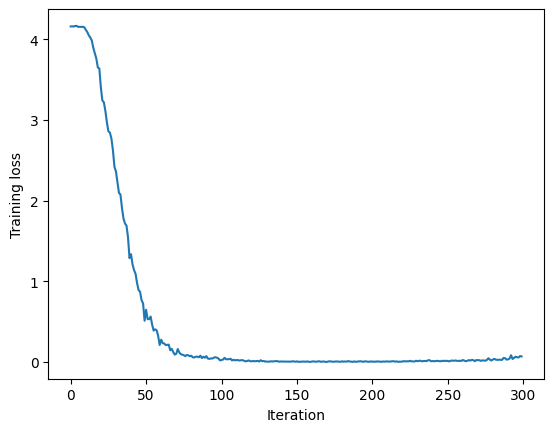

In [26]:
iter_losses, epoch_losses = train_ssl_model(model,aggregator,nn.CrossEntropyLoss(),permuted_images.to(device),y_labels.to(device),lr=0.001,
                                     batch_size=1024, epochs=30, verbose=True)

plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")


In [27]:
y_pred = predict_permutations(model,aggregator,permuted_images,y_labels)
results(y_labels,y_pred)

Accuracy = 0.9908999800682068


In [28]:
# using ssl model parameters as pretrained to train efficientnet classifier
for i in range(30,0,-10):
    if os.path.exists(f"/home/vannsh.jani/brick_kilns/githubrepo/Machine-Learning/model_{i}.pth"):
        path = f"/home/vannsh.jani/brick_kilns/githubrepo/Machine-Learning/model_{i}.pth"
        path_a = f"/home/vannsh.jani/brick_kilns/githubrepo/Machine-Learning/aggregator_{i}.pth"
        break
if os.path.exists(f"/home/vannsh.jani/brick_kilns/githubrepo/Machine-Learning/model_{29}.pth"):
    path = f"/home/vannsh.jani/brick_kilns/githubrepo/Machine-Learning/model_{29}.pth"
    path_a = f"/home/vannsh.jani/brick_kilns/githubrepo/Machine-Learning/aggregator_{29}.pth"
print(path,path_a)


/home/vannsh.jani/brick_kilns/githubrepo/Machine-Learning/model_29.pth /home/vannsh.jani/brick_kilns/githubrepo/Machine-Learning/aggregator_29.pth


### Training model on 1% Train set with SSL

Loss: 0.00519295: 100%|██████████| 30/30 [00:01<00:00, 21.99it/s]


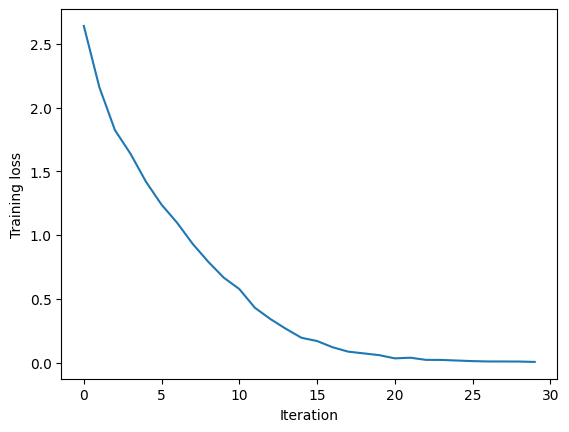

100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


In [29]:
ecf = EfficientNetClassifier(dense_hidden_dims=[1280,1024,256],n_classes=10).to(device)
ecf.featurizer.load_state_dict(torch.load(path))
last_layer = ecf.classifier.classifier
last_layer_aggregator = aggregator.classifier
layers = list(ecf.classifier.children())[:-1]
# set mlp weights as classifier weights
layers_mlp = list(aggregator.children())[:-1]
# removed the input layer in layers_mlp
list(aggregator.children())[0].input_layer = list(aggregator.children())[0].hidden_layer_1
list(aggregator.children())[0].hidden_layer_1 = list(aggregator.children())[0].hidden_layer_2
list(aggregator.children())[0].hidden_layer_2 = nn.Identity()
layers_mlp_matched = list(aggregator.children())[0]

layers = layers_mlp_matched
ecf.classifier = nn.Sequential(*[layers])
aggregator = nn.Sequential(*[layers_mlp_matched])
ecf.classifier.load_state_dict(aggregator.state_dict())
layers_1 = list(ecf.classifier.children())
layers_1.append(last_layer)
ecf.classifier = nn.Sequential(*layers_1)

iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx_1], y[train_idx_1], lr=3e-4,verbose=True,batch_size=256,epochs=30)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()
predict(ecf,X[test_idx],y[test_idx],"1%","yes_SSL")

In [30]:
aggregator = MLPClassifier(1280*9,[1280,1024,256],n_classes=64).to(device)
aggregator.load_state_dict(torch.load(path_a))

<All keys matched successfully>

### Training model on 5% Train set with SSL

Loss: 0.00719051: 100%|██████████| 30/30 [00:02<00:00, 10.37it/s]


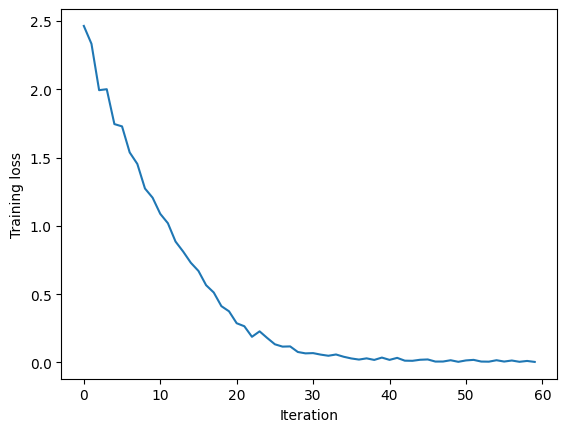

100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


In [31]:
ecf = EfficientNetClassifier(dense_hidden_dims=[1280,1024,256],n_classes=10).to(device)
ecf.featurizer.load_state_dict(torch.load(path))
last_layer = ecf.classifier.classifier
last_layer_aggregator = aggregator.classifier
layers = list(ecf.classifier.children())[:-1]
# set mlp weights as classifier weights
layers_mlp = list(aggregator.children())[:-1]
# removed the input layer in layers_mlp
list(aggregator.children())[0].input_layer = list(aggregator.children())[0].hidden_layer_1
list(aggregator.children())[0].hidden_layer_1 = list(aggregator.children())[0].hidden_layer_2
list(aggregator.children())[0].hidden_layer_2 = nn.Identity()
layers_mlp_matched = list(aggregator.children())[0]

layers = layers_mlp_matched
ecf.classifier = nn.Sequential(*[layers])
aggregator = nn.Sequential(*[layers_mlp_matched])
ecf.classifier.load_state_dict(aggregator.state_dict())
layers_1 = list(ecf.classifier.children())
layers_1.append(last_layer)
ecf.classifier = nn.Sequential(*layers_1)

iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx_5], y[train_idx_5], lr=3e-4,verbose=True,batch_size=256,epochs=30)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()
predict(ecf,X[test_idx],y[test_idx],"5%","yes_SSL")

In [32]:
aggregator = MLPClassifier(1280*9,[1280,1024,256],n_classes=64).to(device)
aggregator.load_state_dict(torch.load(path_a))

<All keys matched successfully>

### Training model on 10% Train set with SSL

Loss: 0.01883169: 100%|██████████| 30/30 [00:05<00:00,  5.68it/s]


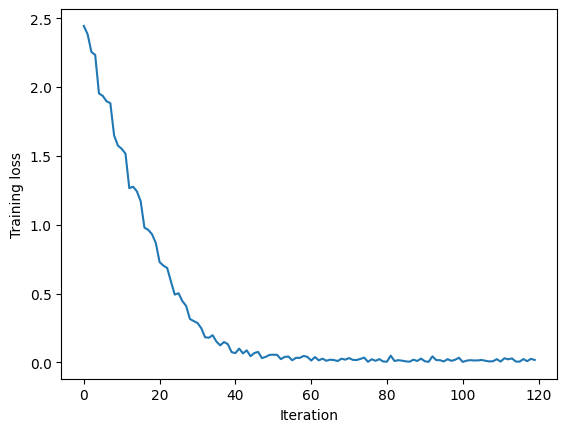

100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


In [33]:
ecf = EfficientNetClassifier(dense_hidden_dims=[1280,1024,256],n_classes=10).to(device)
ecf.featurizer.load_state_dict(torch.load(path))
last_layer = ecf.classifier.classifier
last_layer_aggregator = aggregator.classifier
layers = list(ecf.classifier.children())[:-1]
# set mlp weights as classifier weights
layers_mlp = list(aggregator.children())[:-1]
# removed the input layer in layers_mlp
list(aggregator.children())[0].input_layer = list(aggregator.children())[0].hidden_layer_1
list(aggregator.children())[0].hidden_layer_1 = list(aggregator.children())[0].hidden_layer_2
list(aggregator.children())[0].hidden_layer_2 = nn.Identity()
layers_mlp_matched = list(aggregator.children())[0]

layers = layers_mlp_matched
ecf.classifier = nn.Sequential(*[layers])
aggregator = nn.Sequential(*[layers_mlp_matched])
ecf.classifier.load_state_dict(aggregator.state_dict())
layers_1 = list(ecf.classifier.children())
layers_1.append(last_layer)
ecf.classifier = nn.Sequential(*layers_1)

iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx_10], y[train_idx_10], lr=3e-4,verbose=True,batch_size=256,epochs=30)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()
predict(ecf,X[test_idx],y[test_idx],"10%","yes_SSL")

In [34]:
aggregator = MLPClassifier(1280*9,[1280,1024,256],n_classes=64).to(device)
aggregator.load_state_dict(torch.load(path_a))

<All keys matched successfully>

### Training model on 50% Train set with SSL

Loss: 0.01944705: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


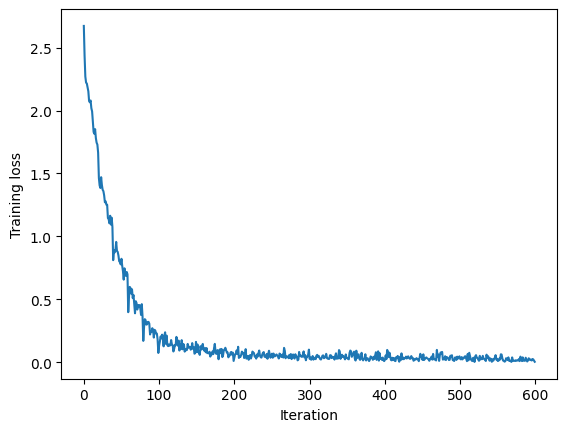

100%|██████████| 1/1 [00:00<00:00, 16.43it/s]


In [35]:
ecf = EfficientNetClassifier(dense_hidden_dims=[1280,1024,256],n_classes=10).to(device)
ecf.featurizer.load_state_dict(torch.load(path))
last_layer = ecf.classifier.classifier
last_layer_aggregator = aggregator.classifier
layers = list(ecf.classifier.children())[:-1]
# set mlp weights as classifier weights
layers_mlp = list(aggregator.children())[:-1]
# removed the input layer in layers_mlp
list(aggregator.children())[0].input_layer = list(aggregator.children())[0].hidden_layer_1
list(aggregator.children())[0].hidden_layer_1 = list(aggregator.children())[0].hidden_layer_2
list(aggregator.children())[0].hidden_layer_2 = nn.Identity()
layers_mlp_matched = list(aggregator.children())[0]

layers = layers_mlp_matched
ecf.classifier = nn.Sequential(*[layers])
aggregator = nn.Sequential(*[layers_mlp_matched])
ecf.classifier.load_state_dict(aggregator.state_dict())
layers_1 = list(ecf.classifier.children())
layers_1.append(last_layer)
ecf.classifier = nn.Sequential(*layers_1)

iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx_50], y[train_idx_50], lr=3e-4,verbose=True,batch_size=256,epochs=30)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()
predict(ecf,X[test_idx],y[test_idx],"50%","yes_SSL")

In [36]:
aggregator = MLPClassifier(1280*9,[1280,1024,256],n_classes=64).to(device)
aggregator.load_state_dict(torch.load(path_a))

<All keys matched successfully>

### Training model on 100% Train set with SSL

Loss: 0.01396491: 100%|██████████| 30/30 [00:53<00:00,  1.78s/it]


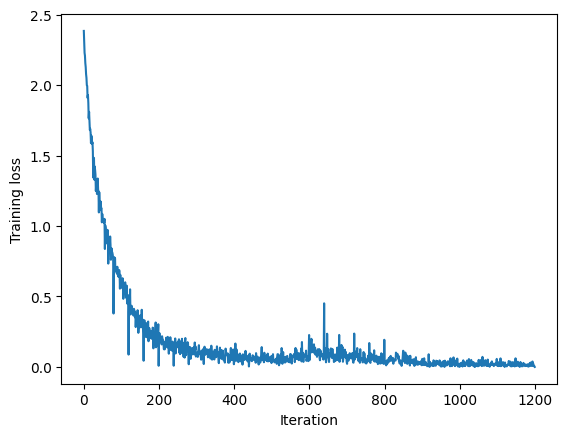

100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


In [37]:
ecf = EfficientNetClassifier(dense_hidden_dims=[1280,1024,256],n_classes=10).to(device)
ecf.featurizer.load_state_dict(torch.load(path))
last_layer = ecf.classifier.classifier
last_layer_aggregator = aggregator.classifier
layers = list(ecf.classifier.children())[:-1]
# set mlp weights as classifier weights
layers_mlp = list(aggregator.children())[:-1]
# removed the input layer in layers_mlp
list(aggregator.children())[0].input_layer = list(aggregator.children())[0].hidden_layer_1
list(aggregator.children())[0].hidden_layer_1 = list(aggregator.children())[0].hidden_layer_2
list(aggregator.children())[0].hidden_layer_2 = nn.Identity()
layers_mlp_matched = list(aggregator.children())[0]

layers = layers_mlp_matched
ecf.classifier = nn.Sequential(*[layers])
aggregator = nn.Sequential(*[layers_mlp_matched])
ecf.classifier.load_state_dict(aggregator.state_dict())
layers_1 = list(ecf.classifier.children())
layers_1.append(last_layer)
ecf.classifier = nn.Sequential(*layers_1)


iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx], y[train_idx], lr=3e-4,verbose=True,batch_size=256,epochs=30)
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()
predict(ecf,X[test_idx],y[test_idx],"100%","yes_SSL")

In [38]:
df = pd.DataFrame(result_dict)
df

,1% no_SSL,5% no_SSL,10% no_SSL,50% no_SSL,100% no_SSL,Oracle no_SSL,1% yes_SSL,5% yes_SSL,10% yes_SSL,50% yes_SSL,100% yes_SSL
accuracy,0.267475,0.420300,0.484550,0.648800,0.709175,0.740200,0.290725,0.427550,0.487925,0.639700,0.702800
f1,0.240804,0.410336,0.483846,0.647661,0.706358,0.740994,0.287227,0.420373,0.486329,0.638396,0.701937
precision,0.280319,0.414238,0.486819,0.654086,0.712212,0.743357,0.297708,0.429746,0.504040,0.639586,0.705633
recall,0.266750,0.420050,0.484293,0.648779,0.708990,0.740180,0.290371,0.427131,0.487604,0.639366,0.702589
